# Optic Chiasm - Tutorial

The [optic chiasm](https://en.wikipedia.org/wiki/Optic_chiasm) is a structure in the brain, where the two nerve fiber bundles from the eyes cross each other.
However not all of the fiber cross the structure.
Depending on the species, a fraction of the nerve fibers stay on the same hemisphere.

### Note

> The here choosen fibers radii and their layer parameters are not realistic. They are just for a fast computation.


## General imports

In [2]:
import fastpli.model.sandbox
import fastpli.model.solver
import fastpli.simulation
import fastpli.analysis
import fastpli.tools
import fastpli.io

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import multiprocessing as mp
import numpy as np
import scipy.interpolate as si

pool = mp.Pool(2)
np.random.seed(42)

Here we just do a simple representation to get an idea of how we can build such a structure.

We start of defining the main fiber bundle geometries, which we will later fill with individual fibers.

We need two crossing trajectories `fb_0` and `fb_1` as well as two kissing trajectories `fb_left` and `fb_right`.
To help for a smoother curve, we use the scipy interpolation function.

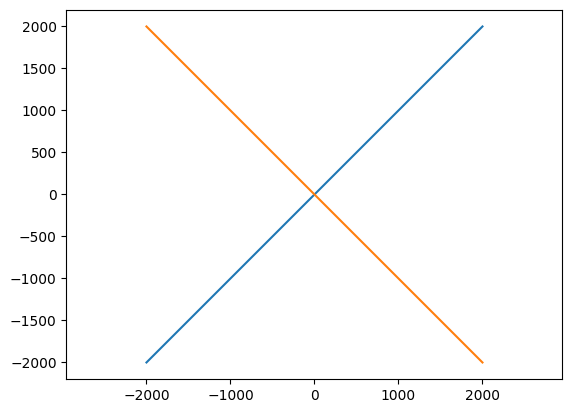

In [3]:

# two crossing main bundle
fb_0 = np.array([[-2000, -2000, 0], [-1000, -1000 ,0], [0,0,0], [1000, 1000,0], [2000, 2000, 0]])
fb_1 = np.array([[-2000, 2000, 0], [-1000, 1000, 0], [0,0,0], [1000, -1000,0], [2000, -2000, 0]])

# # left and right non crossing bundle
# fb_left = np.array([[-2000,-2000,0], [-1050,-1000,0], [-300,0,0], [-1050,1000,0], [-2000,2000,0]])
# fb_right = fb_left.copy()
# fb_right[:,0] *= -1

# # interpolate left and right bundle for smoother
# N = 20
# t = np.linspace(0,1,fb_left.shape[0])
# t_intp = np.linspace(0,1,N)
# fb_left = np.array([si.interp1d(t, fb_left[:,0], 'quadratic')(t_intp), si.interp1d(t, fb_left[:,1], 'quadratic')(t_intp), si.interp1d(t, fb_left[:,2], 'quadratic')(t_intp)]).T
# fb_right = np.array([si.interp1d(t, fb_right[:,0], 'quadratic')(t_intp), si.interp1d(t, fb_right[:,1], 'quadratic')(t_intp), si.interp1d(t, fb_right[:,2], 'quadratic')(t_intp)]).T

fig, ax = plt.subplots(1,1)
plt.plot(fb_0[:,0], fb_0[:,1])
plt.plot(fb_1[:,0], fb_1[:,1])
# plt.plot(fb_left[:,0], fb_left[:,1])
# plt.plot(fb_right[:,0], fb_right[:,1])
ax.axis('equal')
plt.show()


Now we can fill the bundles with fibers.
To account for additional varirity we use a random sampling of radii.
The `sandbox.build.bundle` methods helps us to generate the filled fiber bundles `ffb_*`

In [4]:
population = fastpli.model.sandbox.seeds.triangular_circle(8, 2)
fiber_radii = np.random.uniform(5.0, 10.0, population.shape[0])
ffb_0 = fastpli.model.sandbox.build.bundle(fb_0, population, fiber_radii)
ffb_1 = fastpli.model.sandbox.build.bundle(fb_1, population, fiber_radii)

population = fastpli.model.sandbox.seeds.triangular_circle(4, 2)
fiber_radii = np.random.uniform(5.0, 10.0, population.shape[0])
# ffb_left = fastpli.model.sandbox.build.bundle(fb_left, population, fiber_radii)
# ffb_right = fastpli.model.sandbox.build.bundle(fb_right, population, fiber_radii)

Now we have our initial structure.
However the individual fiber most certanly collide with each other.
Therefore we use the `Solver` to help us.

### Note

> The `Solver` class provides a `Solver.draw_scene()` method.
> However you should not use this in a jupyter notebook, since its current design does not allow a second initialization of the underlying _OpenGL_ structure.
> See `examples/optic_chiasm.py` for this.
> To have a animated view, we use IPython's display function

> Also be carefull with the number of fibers and fiber segments (i. e. obj_mean_length).
> Depending on the configurations, the computational complexity can increase by `O(n_segments^2)`

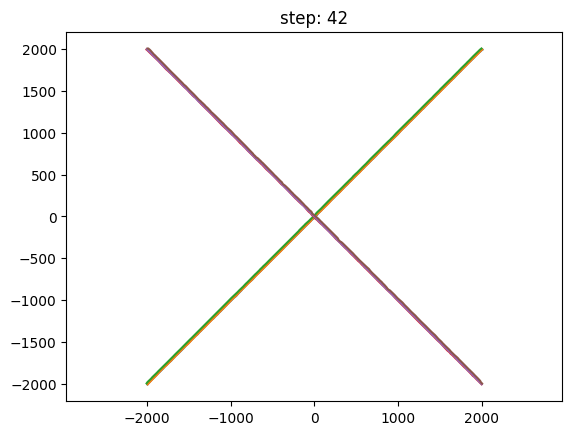

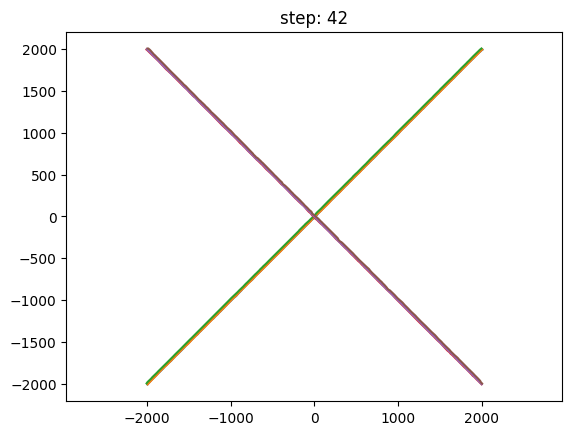

In [5]:
from IPython import display
fig, ax = plt.subplots(1,1)

solver = fastpli.model.solver.Solver()
solver.fiber_bundles = [ffb_0, ffb_1,]# ffb_left, ffb_right
solver.obj_min_radius = 15
solver.obj_mean_length = 15
solver.omp_num_threads = 2

for i in range(43):
    solved = solver.step()
    if i % 42 == 0:
        for fb in solver.fiber_bundles:
            for f in fb:
                # show only the middle section of fibers
                if np.any(f[:,2] > 50) or np.any(f[:,2] < -50):
                    plt.plot(f[:,0], f[:,1])
        ax.axis('equal')
        ax.set_title(f'step: {i}')
        display.clear_output(wait=True)
        display.display(fig)
    if solved:
        break

Now that we have our model we want to simulate it inside a virtual 3D-PLI microscope.
We cut out a brain section of 4000x4000x100 µm^3.

### Note

> The simulation takes quite a lot of memory. It's size increases with `O(n_x*n_y*n_z)`.
> The `Simpli.memory_usage()` method gives you a hint how much memory is needed.

In [13]:
simpli = fastpli.simulation.Simpli()
simpli.omp_num_threads = 2
simpli.voxel_size = 1  # in micro meter
simpli.set_voi([-200, -200, -50], [200, 200, -45])  # in micro meter
simpli.fiber_bundles = solver.fiber_bundles
simpli.fiber_bundles.layers = [[(1.0, -0.0001, 10, 'p')]] * len(
        simpli.fiber_bundles)
print('Memory:', str(round(simpli.memory_usage('MB'), 2)) + ' MB')        

Memory: 15.26 MB


Next we generate the discreticed volume

In [14]:
tissue, optical_axis, tissue_properties = simpli.generate_tissue()

/home/tim/.local/lib/python3.10/site-packages/fastpli/simulation/simpli.py:88: UserWarning: objects overlap
  tissue, optical_axis, tissue_properties = self.__gen.run_generation(


and after defining the microscopic parameters

In [15]:
simpli.filter_rotations = np.deg2rad([0, 30, 60, 90, 120, 150])
simpli.light_intensity = 26000  # a.u.
simpli.wavelength = 525  # in nm
simpli.pixel_size = 10  # in micro meter
simpli.optical_sigma = 0.71  # in pixel size
simpli.noise_model = lambda x: np.random.negative_binomial(
    x / (3 - 1), 1 / 3)
simpli.tilts = np.deg2rad([(0, 0), (5.5, 0), (5.5, 90),
                            (5.5, 180), (5.5, 270)])

we can simulate and analyse our measurement

In [16]:
tilting_stack = []
for theta, phi in simpli.tilts:
    print(f"Tilt: theta={np.rad2deg(theta):.1f}, phi={np.rad2deg(phi):.1f}")
    images = simpli.run_simulation(tissue, optical_axis, tissue_properties,
                                    theta, phi)

    _, images = simpli.apply_optic(images)
    tilting_stack.append(images)

transmittance, direction, retardation = simpli.apply_epa(tilting_stack[0])
rofl_direction, rofl_incl, rofl_t_rel, _ = simpli.apply_rofl(tilting_stack, mp_pool=pool)
fom = fastpli.analysis.images.fom_hsv_black(rofl_direction, rofl_incl)
rofl_direction, rofl_incl, rofl_t_rel = rofl_direction[:,:,None], rofl_incl[:,:,None], rofl_t_rel[:,:,None]

Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0


# More lairs

In [17]:
np.array(tilting_stack).shape

(5, 40, 40, 6)

In [19]:
for i in np.arange(1,20):
    simpli = fastpli.simulation.Simpli()
    simpli.omp_num_threads = 2
    simpli.voxel_size = 1  # in micro meter
    simpli.set_voi([-200, -200, int(i*5)], [200, 200, int(i*5+5)])  # in micro meter
    simpli.fiber_bundles = solver.fiber_bundles
    simpli.fiber_bundles.layers = [[(1.0, -0.0001, 10, 'p')]] * len(
            simpli.fiber_bundles)
    print('Memory:', str(round(simpli.memory_usage('MB'), 2)) + ' MB')        
    tissue, optical_axis, tissue_properties = simpli.generate_tissue()


    simpli.filter_rotations = np.deg2rad([0, 30, 60, 90, 120, 150])
    simpli.light_intensity = 26000  # a.u.
    simpli.wavelength = 525  # in nm
    simpli.pixel_size = 10  # in micro meter
    simpli.optical_sigma = 0.71  # in pixel size
    simpli.noise_model = lambda x: np.random.negative_binomial(
        x / (3 - 1), 1 / 3)
    simpli.tilts = np.deg2rad([(0, 0), (5.5, 0), (5.5, 90),
                                (5.5, 180), (5.5, 270)])


    tilting_stack = []
    for theta, phi in simpli.tilts:
        print(f"Tilt: theta={np.rad2deg(theta):.1f}, phi={np.rad2deg(phi):.1f}")
        images = simpli.run_simulation(tissue, optical_axis, tissue_properties,
                                        theta, phi)

        _, images = simpli.apply_optic(images)
        tilting_stack.append(images)

    transmittance, direction, retardation = simpli.apply_epa(tilting_stack[0])
    rofl_direction1, rofl_incl1, rofl_t_rel1, _ = simpli.apply_rofl(tilting_stack, mp_pool=pool)
    # fom1 = fastpli.analysis.images.fom_hsv_black(rofl_direction, rofl_incl)


    rofl_direction = np.concatenate((rofl_direction, rofl_direction1[:,:,None]), axis=2)
    rofl_incl = np.concatenate((rofl_incl, rofl_incl1[:,:,None]), axis=2)
    rofl_t_rel = np.concatenate((rofl_t_rel, rofl_t_rel1[:,:,None]), axis=2)


Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.

/home/tim/.local/lib/python3.10/site-packages/fastpli/simulation/simpli.py:95: UserWarning: All labels are 0. Usually this means, that the VOI contains no fiber_bundles or that the voxel_size is to large.
  warnings.warn(


Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0
Memory: 15.26 MB
Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0


In [20]:
import odf3
rofl_direction.shape

(40, 40, 20)

In [21]:
odfs = odf3.compute(rofl_direction[:,:,:,None],rofl_incl[:,:,:,None],np.ones(rofl_direction[:,:,:,None].shape), 10)

In [38]:
odfs = odf3.compute(rofl_direction2,rofl_incl2,np.ones(rofl_direction2.shape), 6)

In [55]:
odfs.shape

(20, 20, 20, 66)

In [22]:
np.save("7_ODF_test_fastpli", odfs)

In [3]:
from main_lib import *

# Cache erstellen
factor = 50
range_r = 3
bands = 10
dict_4_10, dict_basis = load_dict(range_r, factor), load_dict(range_r, factor+1)
x_koord, y_koord, z_koord = 25,25,25

bands = 10
# Anzahl der Winkel festlegen
number_of_winkel = 1000
# Daten einlesen/Generieren
## Daten Generieren Y-Shape
ODFs = get_Y_Odfs_noise()
sigma = 0.1
factor_amp = 1000
AODFs = np.empty((20,20,20,odf.get_num_coeff(bands)))
for i in range(15,35):
    for j in range(15,35):
        for k in range(15,35):
            AODF_single = Get_AODF(ODFs,dict_4_10, dict_basis,factor,i,j,k, sigma=sigma, factor_amp=factor_amp, number_of_winkel=number_of_winkel)
            AODFs[i-15,j-15,k-15,:] = AODF_single[0,0,0,:]

np.save(f"9_AODF_npsave_121_new", AODFs)
# 6_ODF_fastpli_factor{factor}_ranger{range_r}_sigma{sigma}_factoramp{factor_amp}_numerWinkel{number_of_winkel}_bands{odf.get_num_coeff(bands)}

(20, 20, 20, 121)
(20, 20, 121)
asymetric: True


RFBOutputContext()

libEGL warning: DRI2: failed to authenticate
rendering odfs: 100%|██████████| 400/400 [00:13<00:00, 29.45it/s]


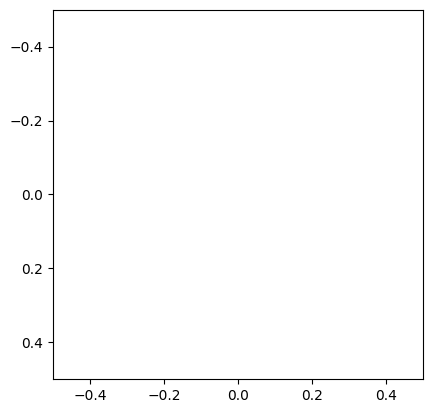

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import vispy_odf


args_name = "9_AODF_npsave_121_new"
args_coefficient = 0.8
odf_coeff = np.load(f"{args_name}.npy") # Crossing_npsave
# odf_coeff = np.load("ODF_npsave.npy")
print(odf_coeff.shape)
odf_coeff = odf_coeff[:, :, 0, :].squeeze()
print(odf_coeff.shape)

image = vispy_odf.render_scene(odf_coeff*args_coefficient)
plt.imshow(image)
plt.show()


In [23]:
from main_lib import *

# Cache erstellen
factor = 50
range_r = 3
bands = 10
dict_4_10, dict_basis = load_dict(range_r, factor), load_dict(range_r, factor+1)# bands
# load_dict(range_r, factor), load_dict(range_r, factor+1)
# generate_dict_basis_new(range_r, factor, bands)

# Anzahl der Winkel festlegen
number_of_winkel = 1000
# Daten einlesen/Generieren
## Daten Generieren Y-Shape
ODFs = np.load("7_ODF_test_fastpli.npy")
sigma = 0.1
factor_amp = 1000

In [11]:
AODFs = np.empty((20,20,20,odf.get_num_coeff(bands)))
for i in range(0,20):
    for j in range(0,20):
        for k in range(0,1):
            AODF_single = Get_AODF(ODFs,dict_4_10, dict_basis,factor,i,j,k, sigma=sigma, factor_amp=factor_amp, number_of_winkel=number_of_winkel)
            AODFs[i,j,k,:] = AODF_single[0,0,0,:]

np.save(f"7_AODF_fastpli_factor{factor}_ranger{range_r}_sigma{sigma}_factoramp{factor_amp}_numerWinkel{number_of_winkel}_bands{odf.get_num_coeff(bands)}", AODFs)

In [3]:
AODFs.shape

(20, 20, 20, 121)

# End more lairs

### Note

All datasets containing spacial information (images, tissue, optical axis) are orded in x-y-z. Since Matplotlib and mostly other visualization libraries or image datasets expect a order of y-x, we have to swap the first two axis first. Additionally we also have to set the origin to 'lower'. Also it is recommendet to use the interpolation method 'nearest'.

In [10]:
rofl_direction.shape

(40, 40, 1)

Text(0.5, 1.0, 'retardation')

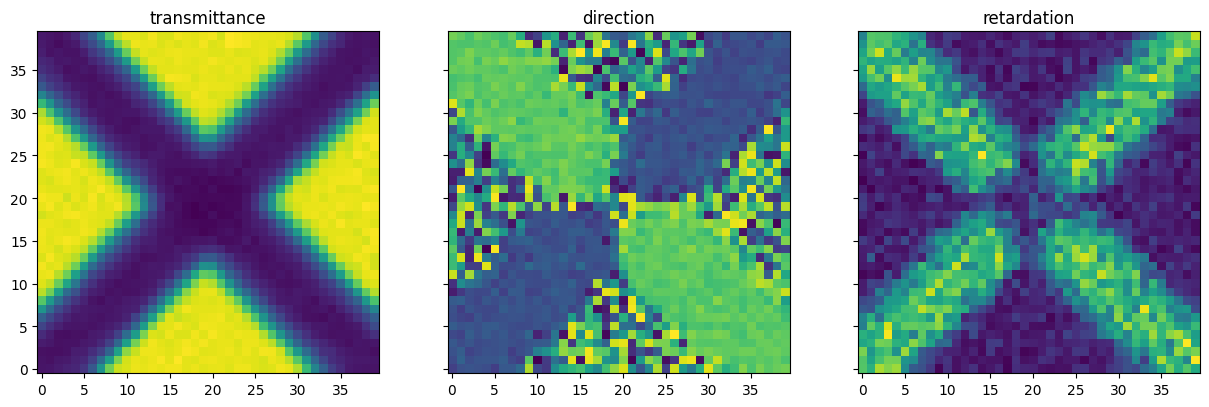

In [11]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,5))
axs[0].imshow(transmittance.T, origin='lower', interpolation='nearest')
axs[0].set_title('transmittance')
axs[1].imshow(direction.T, origin='lower', interpolation='nearest')
axs[1].set_title('direction')
axs[2].imshow(retardation.T, origin='lower', interpolation='nearest')
axs[2].set_title('retardation')

TypeError: Invalid shape (1, 40, 40) for image data

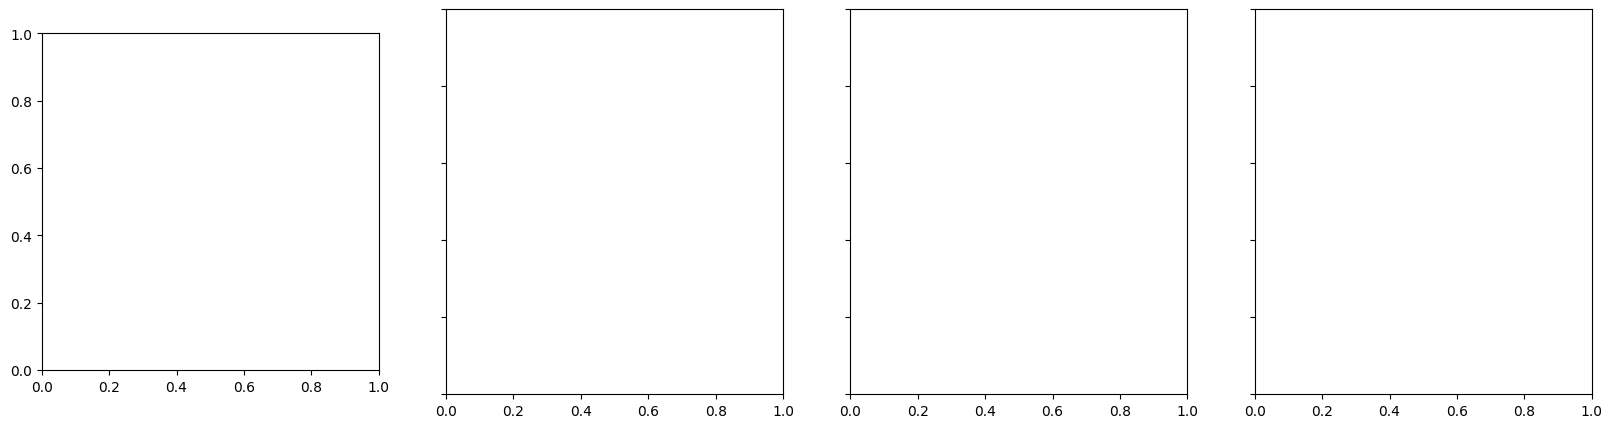

In [12]:
fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))
axs[0].imshow(rofl_direction.T, origin='lower', interpolation='nearest')
axs[0].set_title('direction')
axs[1].imshow(rofl_incl.T, origin='lower', interpolation='nearest')
axs[1].set_title('inclination')
axs[2].imshow(rofl_t_rel.T, origin='lower', interpolation='nearest')
axs[2].set_title('t_rel')
axs[3].imshow(np.swapaxes(fom, 0, 1), origin='lower', interpolation='nearest')
axs[3].set_title('fom')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1,1))
plt.imshow(np.swapaxes(fastpli.analysis.images.hsv_black_sphere(), 0, 1), origin='lower')
plt.axis('off')